In [ ]:
!git clone https://github.com/mit-han-lab/mcunet.git
%cd mcunet
!pip install -r requirements.txt


import sys
sys.path.append('.')

In [ ]:
!mkdir -p assets/sample_images/
!wget https://raw.githubusercontent.com/mit-han-lab/mcunet/master/assets/sample_images/person_det.jpg \
    -O assets/sample_images/person_det.jpg

In [13]:
import os
import numpy as np
import torch
import tensorflow as tf
from PIL import Image, ImageDraw
from mcunet.utils.det_helper import MergeNMS, Yolo3Output
from mcunet.model_zoo import download_tflite

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'# 禁用GPU
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR) #设置 TensorFlow 的日志等级为只输出错误，防止输出太多 warning。

image_path = "assets/sample_images/person_det.jpg"
net_id = "person-det"

tflite_path = download_tflite(net_id=net_id)
interpreter = tf.lite.Interpreter(tflite_path)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
input_shape = input_details[0]['shape']
resolution = input_shape[1:3]


In [14]:
def build_det_helper():
    nms = MergeNMS.build_from_config({
        "nms_name": "merge",
        "nms_valid_thres": 0.01,
        "nms_thres": 0.45,
        "nms_topk": 400,
        "post_nms": 100,
        "pad_val": -1,
    })
    output_configs = [
        {"num_class": 1, "anchors": [116, 90, 156, 198, 373, 326], "stride": 32, "alloc_size": [128, 128]},
        {"num_class": 1, "anchors": [30, 61, 62, 45, 59, 119], "stride": 16, "alloc_size": None},
        {"num_class": 1, "anchors": [10, 13, 16, 30, 33, 23], "stride": 8, "alloc_size": None},
    ]
    outputs = [Yolo3Output(**cfg).eval() for cfg in output_configs]
    return nms, outputs

nms_layer, output_layers = build_det_helper()


In [15]:
def load_example_image(resolution):
    image = Image.open(image_path).convert("RGB")
    image = image.resize(resolution)
    return image

def preprocess_image(image):
    image_np = np.array(image)[None, ...]
    image_np = (image_np / 255) * 2 - 1
    return image_np.astype('float32')

raw_image = load_example_image(resolution[::-1])
input_image = preprocess_image(raw_image)


In [16]:
def eval_image(image):
    interpreter.set_tensor(input_details[0]['index'], image.reshape(*input_shape))
    interpreter.invoke()
    output_data = [interpreter.get_tensor(output_details[i]['index']) for i in range(len(output_details))]
    outputs = [torch.from_numpy(d).permute(0, 3, 1, 2).contiguous() for d in output_data]
    outputs = [output_layer(output) for output_layer, output in zip(output_layers, outputs)]
    outputs = torch.cat(outputs, dim=1)

    ids, scores, bboxes = nms_layer(outputs)
    threshold = 0.3
    n_positive = (scores > threshold).sum()
    ids = ids[0, :n_positive, 0].numpy()
    bboxes = bboxes[0, :n_positive].numpy()

    vis_image = raw_image.copy()
    draw = ImageDraw.Draw(vis_image)
    for cls, bbox in zip(ids, bboxes):
        draw.rectangle(bbox, outline="red", width=2)
        print("Detected class", cls, "at", [round(_) for _ in bbox])

    vis_path = image_path.replace('.jpg', '_vis.jpg')
    vis_image.save(vis_path)
    return vis_image

result = eval_image(input_image)
result.show()

Detected class 0.0 at [21, 10, 102, 126]
Detected class 0.0 at [83, 14, 154, 123]


# What’s the face-detection model looks like?


In MCUNet they do not relese the json file of the person detection, so we can can only try to deploy the model in resberry pi, but we can not change the weights of the model, for do same fancy meth to pruning the weights and quantized it.

# Try to change the model into MCUNet-int4 (do image classification test)

## Evaluate MCUNet-int4

In [ ]:
!git clone https://github.com/mit-han-lab/mcunet.git
%cd mcunet

import sys
sys.path.append('.')

In [ ]:
! pip install thop

In [3]:
import torch
import time
import math
import copy
import random
import logging
import requests
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from tqdm import tqdm
from torch.utils.data import DataLoader
from thop import profile
from thop import clever_format
from torchsummary import summary


In [4]:
random.seed(10)
np.random.seed(10)
torch.manual_seed(10)

## Load CIFAR-10 dataset

In [5]:
class CIFAR:
    """
    CIFAR-10 DataLoader wrapper for MCUNet (160x160 input).
    """
    def __init__(self, batch_size=128, num_workers=2):
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.train_loader, self.test_loader = self.prepare_data()

    def prepare_data(self):
        transform_train = transforms.Compose([
            transforms.Resize((160, 160)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.5]*3, [0.5]*3),
        ])

        transform_test = transforms.Compose([
            transforms.Resize((160, 160)),
            transforms.ToTensor(),
            transforms.Normalize([0.5]*3, [0.5]*3),
        ])

        trainset = torchvision.datasets.CIFAR10(
            root="./data", train=True, download=True, transform=transform_train)
        trainloader = torch.utils.data.DataLoader(
            trainset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)

        testset = torchvision.datasets.CIFAR10(
            root="./data", train=False, download=True, transform=transform_test)
        testloader = torch.utils.data.DataLoader(
            testset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)

        return trainloader, testloader

In [6]:
dataloader = {}
dataloader['train'], dataloader['test'] = CIFAR().train_loader, CIFAR().test_loader

100%|██████████| 170M/170M [00:13<00:00, 13.0MB/s]


## Load MCUNet-IN4


In [7]:
def train(model: nn.Module, train_dataloader: DataLoader, lr=0.1, epochs=10, device="cuda"):
    """
    Training function for training the model using the given dataloader, optimizer, and loss function.

    Args:
        model: The neural network model to be trained.
        train_dataloader: The DataLoader for the training data.
        lr: The learning rate for the optimizer.
        epochs: Number of epochs to train the model.
        device: Device to run the training on ('cuda' or 'cpu').

    Returns:
        None. Prints training progress for each epoch.
    """
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(
        model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4
    )
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=epochs
    )

    for epoch in range(epochs):
        print(f"\nEpoch: {epoch+1}/{epochs}")
        model.train()
        train_loss = 0
        correct = 0
        total = 0

        with tqdm(total=len(train_dataloader), desc=f"Train Epoch {epoch+1}") as pbar:
            for batch_idx, (inputs, targets) in enumerate(train_dataloader):
                inputs, targets = inputs.to(device), targets.to(device)

                optimizer.zero_grad()
                outputs = model(inputs)

                # Compute the loss
                loss = criterion(outputs, targets)

                # Backward pass (backpropagation)
                loss.backward()

                # Optimizer step (update model parameters)
                optimizer.step()

                # Update the running loss and accuracy
                train_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

                pbar.set_postfix(
                    {
                        "Loss": f"{train_loss/(batch_idx+1):.3f}",
                        "Acc": f"{100.0 * correct / total:.3f}%",
                    }
                )
                pbar.update(1)
        scheduler.step()

        epoch_loss = train_loss / len(train_dataloader)
        epoch_acc = 100.0 * correct / total
        print(
            f"Epoch [{epoch+1}/{epochs}] - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%"
        )


In [8]:
# Add evaluation function
def evaluate(model: nn.Module, test_dataloader: DataLoader, device="cuda") -> float:
    """
    Inference function to evaluate the model on a test dataset using the provided dataloader,
    with tqdm progress bar for visualization.

    Args:
        model: The neural network model to be used for inference.
        test_dataloader: The dataloader for the test data.
        device: Device to use ('cuda' or 'cpu').

    Returns:
        None: Prints the accuracy on the test set.
    """
    model = model.to(device)
    model.eval()

    correct = 0
    total = 0

    # Disable gradient computation during inference
    with torch.no_grad():
        for inputs, targets in tqdm(test_dataloader, desc="Evaluating", leave=False):
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            _, predicted = outputs.max(1)

            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    accuracy = 100.0 * correct / total
    # print(f"Accuracy on the test set: {accuracy:.2f}%")
    return accuracy

In [ ]:
# Load the MCUNet-in4 model
from mcunet.model_zoo import build_model

model, resolution, desc = build_model("mcunet-in4")

# Step 2: Modify classifier for CIFAR-10
if hasattr(model, 'classifier'):
    in_features = model.classifier.in_features
    model.classifier = nn.Linear(in_features, 10)
else:
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, 10)
model = model.to("cuda")  # 👈 让模型也搬到 GPU
summary(model, input_size=(3, 160, 160), device="cuda")

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

train(model=model,
      train_dataloader=dataloader['train'],
      lr=0.01,
      epochs=3,
      device=device)

test_acc = evaluate(model=model,
                    test_dataloader=dataloader['test'],
                    device=device)

print(f"\n🎯 Final Test Accuracy: {test_acc:.2f}%")

In [14]:
test_acc = evaluate(model,  dataloader['test'], device="cuda")
print(f"✅ Test Accuracy: {test_acc:.2f}%")

✅ Test Accuracy: 94.85%


In [16]:
torch.save(model.state_dict(), "mcunet_cifar10.pth")

# Model Optimization

## Pruning

### Tool for test

In [18]:
def test_magnitude_prune(
    test_tensor=torch.tensor([[0.15, -0.22, 0.75, -0.50, 0.60],
                              [-0.05, 0.82, -0.33, 0.19, -0.72],
                              [0.99, 0.03, -0.44, 0.85, -0.13],
                              [0.21, -0.11, 0.45, -0.78, 0.07],
                              [-0.29, 0.53, 0.89, -0.35, 0.46]]),
    test_mask=torch.tensor([[False, False, True, True, True],
                            [False, True, False, False, True],
                            [True, False, False, True, False],
                            [False, False, False, True, False],
                            [False, True, True, False, False]]),
    target_sparsity=0.6):

    def plot_matrix(tensor, ax, title):
        ax.imshow(tensor.cpu().numpy() == 0, vmin=0, vmax=1, cmap='summer')
        ax.set_title(title)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        for i in range(tensor.shape[1]):
            for j in range(tensor.shape[0]):
                text = ax.text(j, i, f'{tensor[i, j].item():.2f}', ha="center", va="center", color="k")

    # Clone the test tensor to avoid modifying the original
    test_tensor = test_tensor.clone()

    # Plot the original dense tensor
    fig, axes = plt.subplots(1, 2, figsize=(6, 10))
    ax_left, ax_right = axes.ravel()
    plot_matrix(test_tensor, ax_left, 'Dense Tensor')

    # Perform magnitude pruning
    pruned_tensor, mask = magnitude_pruning(test_tensor, target_sparsity)

    # Plot the pruned (sparse) tensor
    plot_matrix(pruned_tensor, ax_right, 'Sparse Tensor')
    fig.tight_layout()
    plt.show()

    # Print the results
    print('* Test magnitude_prune()')
    print(f'    Target sparsity: {target_sparsity:.2f}')
    print(f'    Sparsity of pruning mask: {mask.float().mean():.2f}')
    print(f'    Sparsity of pruned tensor: {(pruned_tensor == 0).float().mean():.2f}')
    if target_sparsity == 0.6:
      if test_mask.equal(mask):
          print('* Test passed.')
      else:
          print('* Test failed.')
    else:
      if (mask.float().mean() == 1 - target_sparsity):
          print('* Test passed.')
      else:
          print('* Test failed.')

### Weights distribution Visualization

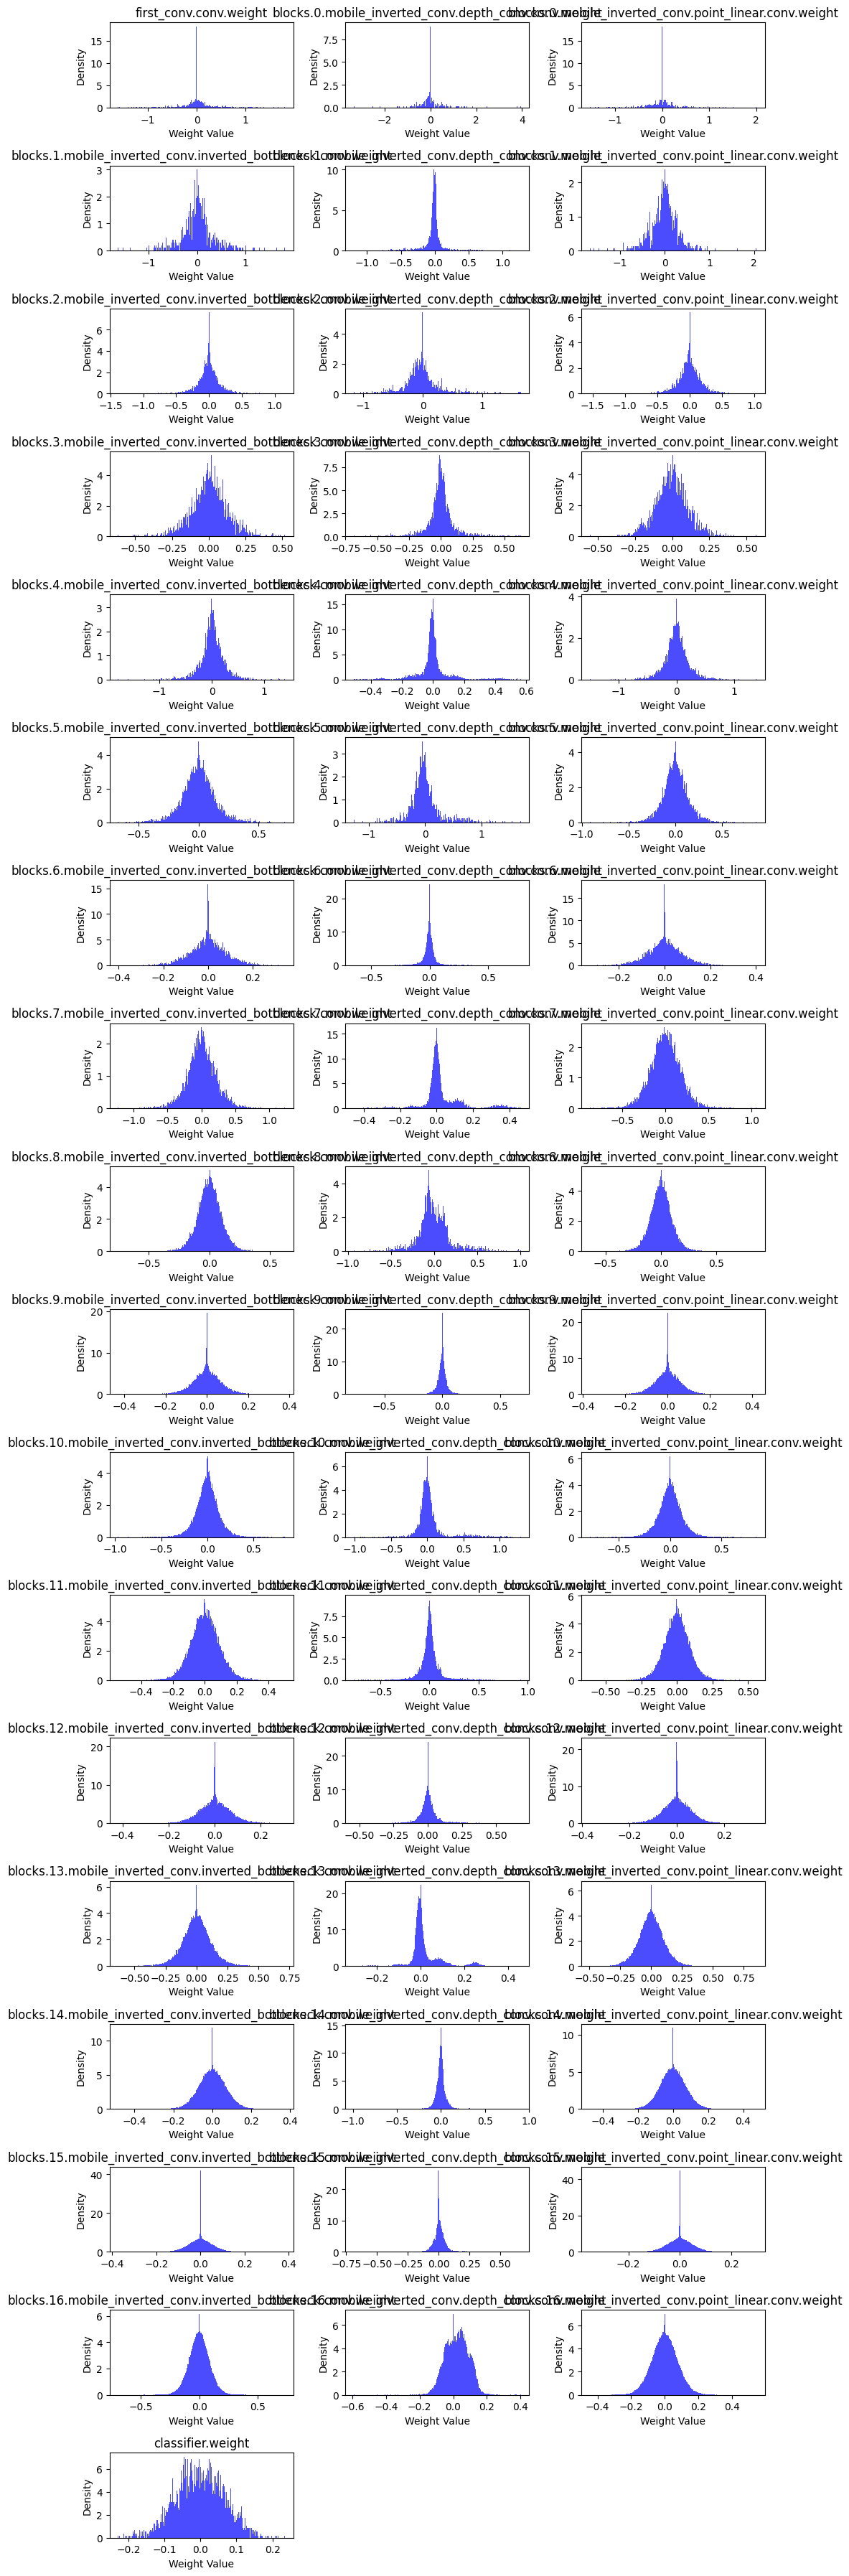

In [22]:
def visualize_weight_distribution(model, bins=256, exclude_zero=False):
    weight_data = [] # Collect weights to be visulized
    layer_names = []

    for layer_name, param_tensor in model.named_parameters():
        if param_tensor.dim() > 1:  # Only consider weight tensors, ignore biases and batch norm
            ##############################################################################
            #TODO: Flatten and move weight data to CPU               #
            ##############################################################################
            param_numpy = param_tensor.detach().cpu().numpy()
            flattened_numpy = param_numpy.flatten()
            weight_data.append(flattened_numpy)
            ##############################################################################
            #END OF YOUR CODE                              #
            ##############################################################################
            layer_names.append(layer_name)  # Collect layer names

    num_layers = len(weight_data)
    columns = 3
    rows = math.ceil(num_layers / columns)

    fig, axes = plt.subplots(rows, columns, figsize=(10, rows * 2))
    axes = axes.flatten()

    for i, (layer_weights, layer_name) in enumerate(zip(weight_data, layer_names)):
        ax = axes[i]
        if exclude_zero:
            layer_weights = layer_weights[layer_weights != 0]
        ax.hist(layer_weights, bins=bins, density=True, color='blue', alpha=0.7)
        ax.set_title(layer_name)
        ax.set_xlabel('Weight Value')
        ax.set_ylabel('Density')

    for j in range(num_layers, len(axes)):
        fig.delaxes(axes[j])
    fig.tight_layout()
    plt.show()

visualize_weight_distribution(model)

### Magnitude Pruning


In [19]:
def magnitude_pruning(tensor: torch.Tensor, sparsity: float) -> torch.Tensor:
    """
    Apply magnitude pruning to a given tensor.

    Args:
        tensor (torch.Tensor): The input tensor to be pruned.
        sparsity (float): The desired spars
    Returns:
        pruned_tensor (torch.Tensor): The pruned tensor.
        mask (torch.Tensor): The pruning mask (where True means the weight is kept, and False means it is pruned).
    """
    sparsity = min(max(0.0, sparsity), 1.0)
    pruned_tensor = tensor.clone()
    mask = torch.zeros_like(tensor, dtype=torch.bool)
    ##############################################################################
    #TODO: Compute pruned_tensor and corresponding mask           #
    ##############################################################################
    # Step 1: Flatten the tensor
    flattened_tensor=pruned_tensor.view(-1)

    # Step 2: Calaulate pruning threshold
    threshold=torch.quantile(flattened_tensor.abs(),sparsity)

    # Step 3: Create a mask
    mask=(tensor.abs()>=threshold)

    # Step 4: Create the pruned tensor
    pruned_tensor=tensor * mask

    # Step 5: Ensure the pruned tensor has correct shape
    pruned_tensor=pruned_tensor.view(tensor.shape)
    mask=mask.view(tensor.shape)

    ##############################################################################
    #END OF YOUR CODE                              #
    ##############################################################################
    mask = mask.to(tensor.device)
    pruned_tensor = pruned_tensor.to(tensor.device)

    return pruned_tensor, mask